<a href="https://colab.research.google.com/github/wujciak/thesis_colab/blob/main/cnn_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieć splotowa
W tym notatniku pokazuje proces przygotowania danych i trenowania modelu opartego na splotowej sieci neuronowej. Trening takiego modelu stanowi porównanie dla treningu modelu opartego o transformery.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

# Normalizacja i podział danych
Przeskalowanie danych oraz zamiana na skalę szarości. W tej sekcji dodatkowo podzielono dane na zbiór walidacyjny i zbiór treningowy, a następnie wyliczono wagi klas na podstawie ich liczebności, tak aby wyrównać różnicę w ilości danych dla obu klas.



In [2]:
# Ścieżka do zbioru danych
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/dataset"

# Parametry stałe
img_height = 256
img_width = 256
batch_size = 16

# Normalizacja i podział datasetu (20% na walidację)
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

# Zbiór treningowy
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['benign', 'malignant'],
    color_mode='grayscale',
    subset='training'
)

# Zbiór walidacyjny
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['benign', 'malignant'],
    color_mode='grayscale',
    subset='validation'
)

# Wyliczenie wag klas ze względu na małą dysproporcję
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Found 7203 images belonging to 2 classes.
Found 1799 images belonging to 2 classes.
Class weights: {0: 1.1587837837837838, 1: 0.8794871794871795}


In [3]:
# Wyświetlenie klas i ich oznaczeń w modelu
class_names = train_generator.class_indices
print(class_names)

{'benign': 0, 'malignant': 1}


Asercja dla pewności, że dane nie zawierają parametrów problematycznych do dalszej ewaluacji modelu. Przy występowaniu Not a Number funkcje nie wyliczałyby poprawnie wyników, a co za tym idzie, model nie wyciągałby odpowiednich wniosków.

In [4]:
# Sprawdzenie czy dane nie zawierają NaN
for images, labels in train_generator:
    assert not np.any(np.isnan(images)), "NaN values found in input data"
    break

for images, labels in val_generator:
    assert not np.any(np.isnan(images)), "NaN values found in input data"
    break

# Prezentacja danych
Pokazanie przykładowych danych po augmentacji.

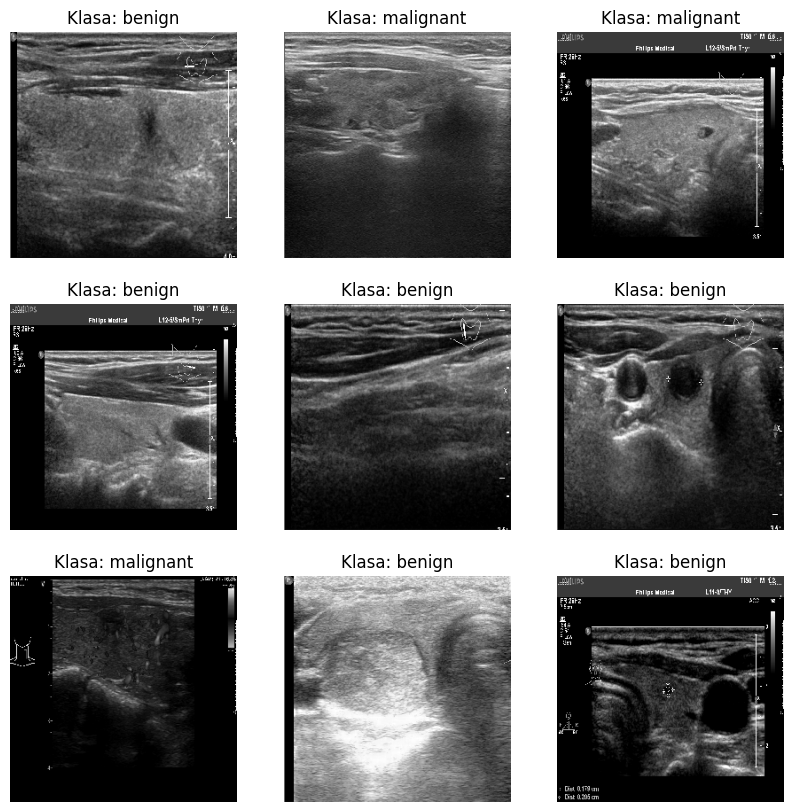

In [5]:
# Wyświetlanie kilku obrazów z klasami
images, labels = next(train_generator)
class_names = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Klasa: {class_names[labels[i]]}")
    plt.axis("off")

plt.show()

Przedstawienie ilościowe danych z podziałem na klasy oraz wykorzystanie ich w procesie uczenia modelu.

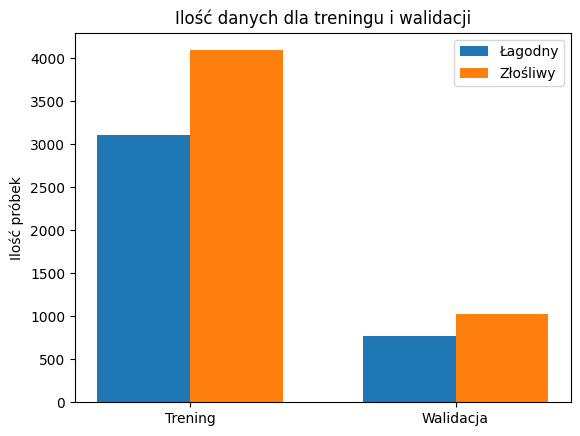

Liczba próbek w całym zbiorze: 9002
Liczba próbek w zbiorze treningowym: 7203
Liczba próbek w zbiorze walidacyjnym: 1799
Liczba próbek łagodnych w zbiorze treningowym: 3108
Liczba próbek złośliwych w zbiorze treningowym: 4095
Liczba próbek łagodnych w zbiorze walidacyjnym: 776
Liczba próbek złośliwych w zbiorze walidacyjnym: 1023


In [6]:
# Zliczenie ilości danych w każdym zbiorze
train_benign = np.sum(train_generator.classes == 0)
train_malignant = np.sum(train_generator.classes == 1)
val_benign = np.sum(val_generator.classes == 0)
val_malignant = np.sum(val_generator.classes == 1)

# Dane do wykresu
categories = ['Trening', 'Walidacja']
benign_counts = [train_benign, val_benign]
malignant_counts = [train_malignant, val_malignant]

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(categories)) - width/2, benign_counts, width, label='Łagodny')
rects2 = ax.bar(np.arange(len(categories)) + width/2, malignant_counts, width, label='Złośliwy')

ax.set_ylabel('Ilość próbek')
ax.set_title('Ilość danych dla treningu i walidacji')
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.legend()

plt.show()

# Całkowita liczba próbek
total_train_samples = train_generator.samples
total_val_samples = val_generator.samples

# Wyświetlenie liczby danych w formie tekstowej
print(f"Liczba próbek w całym zbiorze: {total_train_samples + total_val_samples}")
print(f"Liczba próbek w zbiorze treningowym: {total_train_samples}")
print(f"Liczba próbek w zbiorze walidacyjnym: {total_val_samples}")
print(f"Liczba próbek łagodnych w zbiorze treningowym: {train_benign}")
print(f"Liczba próbek złośliwych w zbiorze treningowym: {train_malignant}")
print(f"Liczba próbek łagodnych w zbiorze walidacyjnym: {val_benign}")
print(f"Liczba próbek złośliwych w zbiorze walidacyjnym: {val_malignant}")

# Budowa modelu i trening
W tej sekcji pokazano architekturę modelu splotowego oraz parametry jakie zastosowano do trenigu.

In [7]:
# Architektura modelu CNN
model = models.Sequential()
model.add(Input(shape=(img_height, img_width, 1)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.25))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,167,489 (65.49 MB)

 Trainable params: 17,166,529 (65.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-7),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/models/cnn_best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/451 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - accuracy: 0.5409 - loss: 0.9675 
Epoch 1: val_loss improved from inf to 0.69349, saving model to /content/drive/MyDrive/Colab Notebooks/models/cnn_best_model.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 4025s 9s/step - accuracy: 0.5410 - loss: 0.9667 - val_accuracy: 0.5536 - val_loss: 0.6935
Epoch 2/30
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6109 - loss: 0.6560
Epoch 2: val_loss did not improve from 0.69349
451/451 ━━━━━━━━━━━━━━━━━━━━ 87s 189ms/step - accuracy: 0.6110 - loss: 0.6559 - val_accuracy: 0.5314 - val_loss: 0.7557
Epoch 3/30
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6591 - loss: 0.6136
Epoch 3: val_loss did not improve from 0.69349
451/451 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - accuracy: 0.6591 - loss: 0.6136 - val_accuracy: 0.4931 - val_loss: 0.8532
Epoch 4/30
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6788 - loss: 0.5925
Epoch 4: val_loss did not improve from 0.69349
451/451 ━━━━━━━━━━━━━━━━━━━━ 8

# Wyniki uczenia

In [11]:
from sklearn.metrics import classification_report

# Pobranie etykiet
y_true = val_generator.classes

# Przewidywania modelu
y_pred = model.predict(val_generator)
if y_pred.ndim == 2 and y_pred.shape[1] == 1:
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
else:
    y_pred_classes = np.argmax(y_pred, axis=1)

# Raport klasyfikacji
print(classification_report(y_true, y_pred_classes, target_names=['benign', 'malignant']))

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
              precision    recall  f1-score   support

      benign       0.44      0.50      0.47       776
   malignant       0.57      0.51      0.54      1023

    accuracy                           0.51      1799
   macro avg       0.51      0.51      0.50      1799
weighted avg       0.52      0.51      0.51      1799



# Conffusion matrix

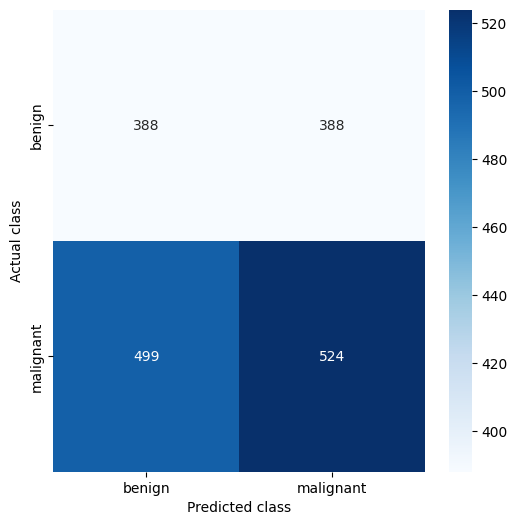

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

# Wykres dokładności i walidacji

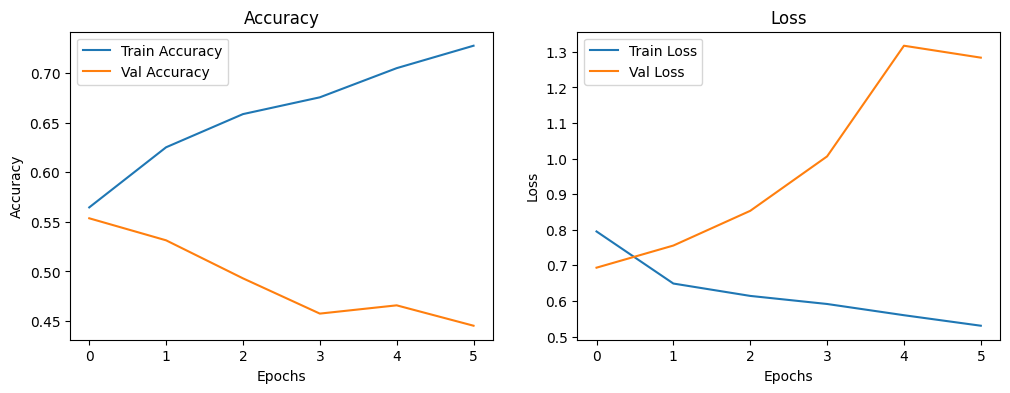

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

# Przykładowe 9 predykcji z modelu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


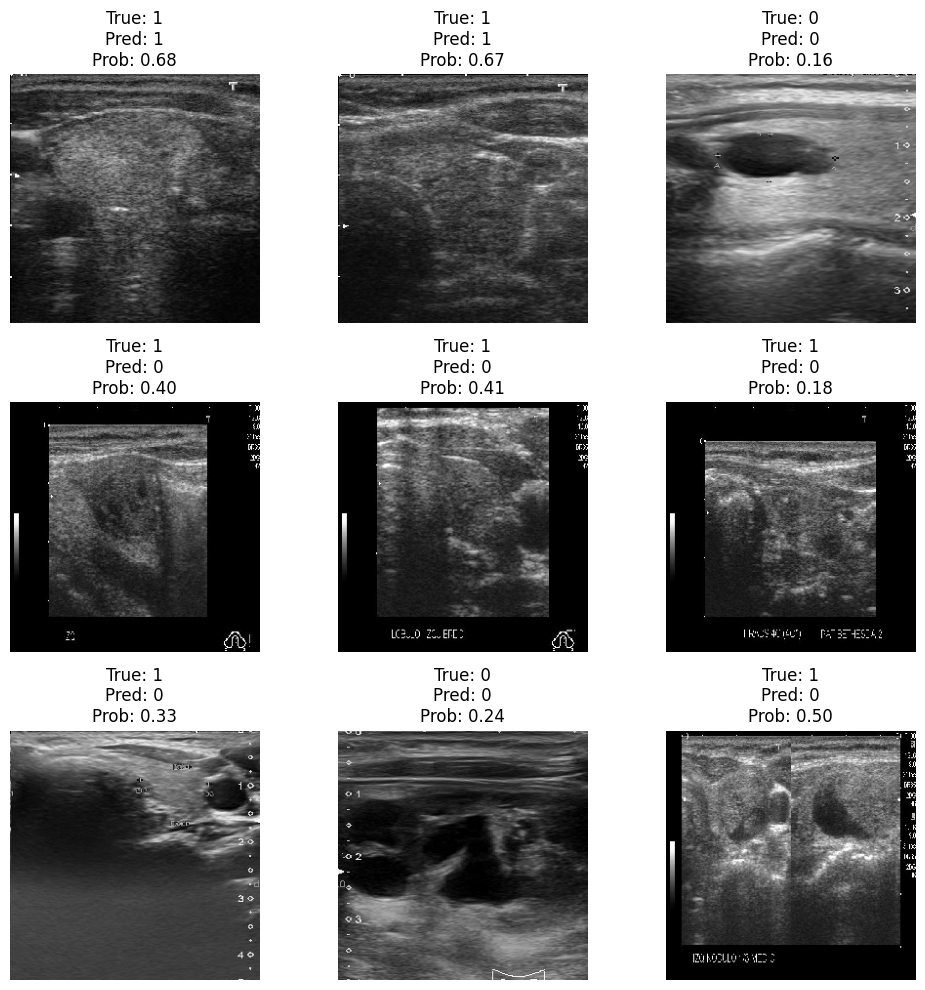

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Pobranie obrazów i etykiet
img, label = next(val_generator)

# Liczba obrazów w siatce (3x3)
num_rows = 3
num_cols = 3
num_images = 9

# Stworzenie siatki wykresów
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(img):
        image = img[i]
        true_label = int(label[i])  # Binarna klasyfikacja, etykieta to 0 lub 1

        # Przewidywanie modelu
        image_input = image[np.newaxis, ...]
        pred_prob = model.predict(image_input)[0][0]
        pred_label = 1 if pred_prob > 0.5 else 0  # Próg 0.5 dla klasyfikacji binarnej

        # Wyświetlenie obrazu z etykietami
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
        ax.axis('off')

plt.tight_layout()
plt.show()